In [171]:
import os
import cv2
import skimage

import numpy as np
import sklearn
import pandas as pd  
import tensorflow as tf

from skimage.transform import resize
from keras.models import load_model
from mtcnn import MTCNN
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
sklearn.__version__

'0.24.2'

In [173]:
image_train_path = '../data/train/'
image_test_path = '../data/test/'
image_dir_path = '../data/train'

names = [ name for name in os.listdir(image_dir_path) if os.path.isdir(os.path.join(image_train_path, name)) ]
print(names)

['ben_afflek', 'madonna', 'elton_john', 'mindy_kaling', 'jerry_seinfeld']


In [174]:
# deep face 
#model_path = '../data/models/deepface/keras/deepface_fn_512.h5'
#model_path = '../data/models/deepface/keras/deepface_fn_128.h5'

# face net
#model_path = '../data/models/facenet/keras/facenet_ds_keras_128.h5'
model_path = '../data/models/facenet/keras/facenet_ds_keras_512.h5'

model = load_model(model_path, compile = False , custom_objects={"tf": tf})


/Users/aro/.local/share/virtualenvs/benchmark-face-reco-47OFH1_E/lib/python3.9/site-packages/keras/layers/core.py:1043: UserWarning: FaceNet is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


In [175]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x)), epsilon))
    return output

In [176]:
def crop_face(image, detector, margin=0, image_size=160):

    image_np = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)

    detected = detector.detect_faces(image_np)

    # if there is more than one face detected the image is rejected
    if len(detected) > 1:
        print('')
        print('-----')
        print(' {} faces detected'.format(len(detected)))
        print('-----')
        return np.empty([])

    face_box = detected[0]['box']

    y = int(max(face_box[0] - margin/2, 0))
    x = int(max(face_box[1] - margin/2, 0))
    h = face_box[2] + margin
    w = face_box[3] + margin

    # save the crop images
    cropped = l2_normalize(image_np[x:x + w, y:y + h, :])
    cropped = image_np[x:x + w, y:y + h, :]

    # crop
    image_resize_np = resize(cropped, (image_size, image_size), mode='reflect')

    return (image_resize_np)

In [177]:

image_dir_path = image_train_path

# MTCNN model
image_size = 160
detector = MTCNN(min_face_size=30)

# faces
faces_emb = []
label = []

for idx, name in enumerate(names):

    name_dir = image_dir_path + name
    image_filepaths = [os.path.join(name_dir, f)
                       for f in os.listdir(name_dir)]

    for iname, image in enumerate(image_filepaths):

        face_resize_np = crop_face(
            image, detector, margin=0, image_size=image_size)
        
        # there is more than one face detected the image is rejected
        if face_resize_np.size > 1 :
            print(idx, end='')
            emb = model.predict_on_batch(np.expand_dims(face_resize_np, axis=0))
            faces_emb.append(emb)
            label.append(name)

# skeeze one dimension 
faces_emb_train_np = np.squeeze(np.array(faces_emb), axis=1)
# define the labels
label_emb_train_np = np.array(label)
    

0000000000000011111111111111111222
-----
 2 faces detected
-----
22222222223333333333333444444444444
-----
 2 faces detected
-----
44444444

In [178]:
faces_emb_train_np.shape

(77, 512)

In [179]:
# instantiate the tsne 
# https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0
tsne = TSNE(n_iter=1500, n_components=2, perplexity=10)

In [180]:
embs_tsne = tsne.fit_transform(faces_emb_train_np)

# Visualisation of the embeddings space 

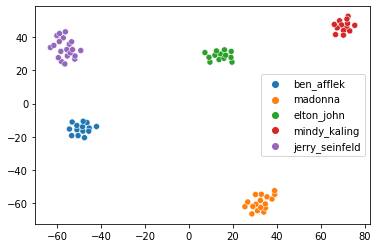

In [181]:
import mpld3
mpld3.enable_notebook()

x = embs_tsne[:, 0]
y = embs_tsne[:, 1]
faces_emb_train_np
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=label_emb_train_np)
plt.show()

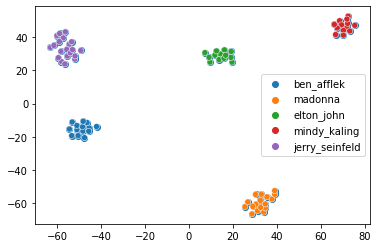

In [182]:
import mpld3
mpld3.enable_notebook()

fig, ax = plt.subplots()
ax.scatter(x, y)
sns.scatterplot(x=x, y=y, hue=label_emb_train_np)
plt.show()

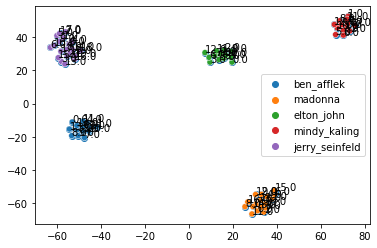

In [183]:
label_idx = np.zeros(len(label_emb_train_np))
for name in label_emb_train_np:
    name_image = label_emb_train_np == name
    label_idx[name_image == True,] = np.array(range(sum(name_image)))

fig, ax = plt.subplots()
ax.scatter(x, y)

p1 = sns.scatterplot(x=x, y=y, hue=label_emb_train_np)
for i, txt in enumerate(label_idx):
    p1.annotate(txt, (x[i], y[i]))
plt.show()

In [184]:
mpld3.disable_notebook()

# Unsupervised learning

#### K-NN

KNNclassifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                  metric='minkowski', metric_params=None, n_jobs=None)

In [185]:
image_dir_path = image_test_path

# MTCNN model
image_size = 160
detector = MTCNN(min_face_size=30)

# faces
faces_emb = []
label = []

for idx, name in enumerate(names):

    name_dir = image_dir_path + name
    image_filepaths = [os.path.join(name_dir, f)
                       for f in os.listdir(name_dir)]

    for iname, image in enumerate(image_filepaths):

        face_resize_np = crop_face(
            image, detector, margin=0, image_size=image_size)
        
        # there is more than one face detected the image is rejected
        if face_resize_np.size > 1 :
            print(idx, end='')
            emb = model.predict_on_batch(np.expand_dims(face_resize_np, axis=0))
            faces_emb.append(emb)
            label.append(name)

# skeeze one dimension 
faces_emb_test_np = np.squeeze(np.array(faces_emb), axis=1)
# define the labels
label_emb_test_np = np.array(label)

00000111112222222
-----
 2 faces detected
-----
333333333333344444

In [186]:
# instantiate the tsne 
tsne = TSNE(n_iter=15000, n_components=2, perplexity=10)
# compute the TSNE of the embeddings
embs_tsne = tsne.fit_transform(faces_emb_test_np)

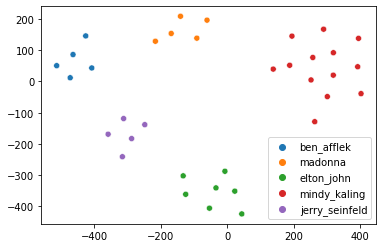

In [187]:
x = embs_tsne[:, 0]
y = embs_tsne[:, 1]
faces_emb_train_np
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=label_emb_test_np)
plt.show()

# Train and test a classifier to recognise faces
> read the doc on KNN 
>> https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [155]:
# import KNN
from sklearn.neighbors import KNeighborsClassifier

In [156]:
# instanciate the classifier
KNNclassifier = KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='brute', n_jobs=None)

In [157]:
# fit on training set
X_train = faces_emb_train_np
y_train = label_emb_train_np
KNNclassifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=10)

In [158]:
# Evaluate on test set
X_test = faces_emb_test_np
y_predict_test_np = KNNclassifier.predict(X_test)

# Analyse the performance of the classifier 

In [159]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

a = accuracy_score (y_true = label_emb_test_np , y_pred = y_predict_test_np)

In [160]:
print(classification_report(y_true  = label_emb_test_np , y_pred = y_predict_test_np))

                precision    recall  f1-score   support

    ben_afflek       1.00      1.00      1.00         5
    elton_john       1.00      1.00      1.00         7
jerry_seinfeld       1.00      1.00      1.00         5
       madonna       1.00      1.00      1.00         5
  mindy_kaling       1.00      1.00      1.00        13

      accuracy                           1.00        35
     macro avg       1.00      1.00      1.00        35
  weighted avg       1.00      1.00      1.00        35



In [161]:
# for sake of readibility we generate short names with the 3 first letters of each names
short_names = [name[:3] for name in names ]

In [162]:
# function to analyse the grid search outputs
def print_grid_search(grid_search, param_grid):
    # read the best score and the best parameters
    best_param = grid_search.best_estimator_.get_params()
    best_score = grid_search.best_score_
    print('Best score :')
    print('===========')
    print('Mean cross-validated score of the best_estimator :')
    print(best_score)
    # read best parameters
    print()
    print('Best Parameters :')
    print('================')
    print('Parameter setting that gave the best results on the hold out data.')
    for param_name in param_grid[0].keys():
        print(param_name, " = ", best_param[param_name])

In [163]:
from sklearn.model_selection import GridSearchCV

param_grid = [{ 'n_neighbors' : [1,2,5,10,15,20]}]
estimator = KNeighborsClassifier( weights='uniform', algorithm='brute', n_jobs=None)

grid_search_knn = GridSearchCV(
    estimator = estimator , param_grid = param_grid , verbose=1, cv=5, n_jobs=-1,return_train_score=True)


In [164]:
%%time
grid_search_knn_res = grid_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 96.4 ms, sys: 193 ms, total: 290 ms
Wall time: 1.79 s


In [165]:
print_grid_search(grid_search_knn_res,param_grid )

Best score :
Mean cross-validated score of the best_estimator :
1.0

Best Parameters :
Parameter setting that gave the best results on the hold out data.
n_neighbors  =  1


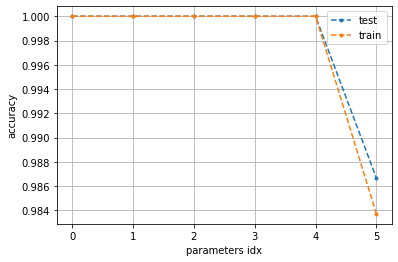

In [166]:
import matplotlib.pyplot as plt

mean_test_score = grid_search_knn_res.cv_results_['mean_test_score']
mean_train_score = grid_search_knn_res.cv_results_['mean_train_score']

plt.figure()
plt.plot(mean_test_score,label = 'test', marker = '.', linestyle='dashed')
plt.plot(mean_train_score, label = 'train',  marker = '.', linestyle='dashed')
plt.xlabel('parameters idx')
plt.ylabel('accuracy')
plt.legend()
plt.grid()


In [167]:
# then evaluate on the test set
# refit on the whole training set is performed by default
# the result is best_estimator_
X_test = faces_emb_test_np
y_test = label_emb_test_np
best_estimator = grid_search_knn_res.best_estimator_
y_test_esti = best_estimator.predict(X_test)
print(classification_report(y_test, y_test_esti, target_names=names))

                precision    recall  f1-score   support

    ben_afflek       1.00      1.00      1.00         5
       madonna       1.00      1.00      1.00         7
    elton_john       1.00      1.00      1.00         5
  mindy_kaling       1.00      1.00      1.00         5
jerry_seinfeld       1.00      1.00      1.00        13

      accuracy                           1.00        35
     macro avg       1.00      1.00      1.00        35
  weighted avg       1.00      1.00      1.00        35



# Confusion matrix 
> https://en.wikipedia.org/wiki/Confusion_matrix <br>
> with scikit learn 

> plot the confusion matrix: 
>> y_true = label_emb_test_np <br>
>> y_pred = y_predict_test_np  <br>
>> labels =short names generated precedingly <br> 

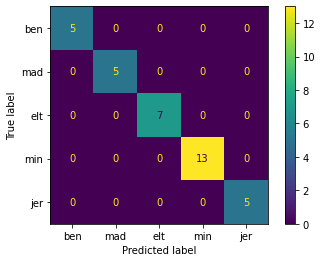

In [168]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=label_emb_test_np,
                      y_pred=y_predict_test_np, labels=names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_names)
disp.plot()
plt.show()

In [123]:
label_emb_test_np

array(['ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek',
       'ben_afflek', 'madonna', 'madonna', 'madonna', 'madonna',
       'madonna', 'elton_john', 'elton_john', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'elton_john', 'mindy_kaling',
       'mindy_kaling', 'mindy_kaling', 'mindy_kaling', 'mindy_kaling',
       'mindy_kaling', 'mindy_kaling', 'mindy_kaling', 'mindy_kaling',
       'mindy_kaling', 'mindy_kaling', 'mindy_kaling', 'mindy_kaling',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld'], dtype='<U14')

In [170]:
list(range(2,4))

[2, 3]